In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from env import user, password, host
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import os
import csv

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def acquire_zillow():
    file='zillow2017_df.csv'
    if os.path.isfile(file):
        return pd.read_csv(file)
    else:
        zillow2017_df = pd.read_sql(('SELECT bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips,lotsizesquarefeet,regionidzip,assessmentyear,transactiondate FROM properties_2017 JOIN propertylandusetype USING (propertylandusetypeid) JOIN predictions_2017 USING (id) WHERE propertylandusedesc IN ("Single Family Residential")'), get_connection('zillow'))
        zillow2017_df.to_csv(file,index=False)
    return zillow2017_df

In [4]:
def clean_column():
    zillow2017_df=acquire_zillow()
    zillow2017_df.rename(columns={'bedroomcnt':'bedroom','bathroomcnt':'bathroom','calculatedfinishedsquarefeet':'sqtft','taxvaluedollarcnt':'taxvalue','garagecarcnt':'garage','lotsizesquarefeet':'lots','poolcnt':'pool','regionidzip':'zipcode'},inplace=True)
    zillow2017_df['fips']= zillow2017_df['fips'].astype(object)
    zillow2017_df['yearbuilt']=zillow2017_df['yearbuilt'].astype(object)
    zillow2017_df['assessmentyear']=zillow2017_df['assessmentyear'].astype(object)
    zillow2017_df['zipcode']=zillow2017_df['zipcode'].astype(object)
    return zillow2017_df

In [5]:
def remove_outlier(k):
    zillow2017_df=clean_column()
    col_list=zillow2017_df.select_dtypes(float)
    for col in col_list:
        q1, q3 = zillow2017_df[col].quantile([.25, .75]) 
        iqr = q3 - q1  
        upper_bound = q3 + k * iqr  
        lower_bound = q1 - k * iqr  
        zillow2017_df = zillow2017_df[(zillow2017_df[col] > lower_bound) & (zillow2017_df[col] < upper_bound)]
        zillow2017_df.dropna()
    return zillow2017_df

In [6]:
def get_hist(k):
    zillow2017_df=remove_outlier(k)
    plt.figure(figsize=(16, 3))
    cols = zillow2017_df.select_dtypes(float).columns
    for i, col in enumerate(cols):
        plot_num = i + 1 
        plt.subplot(1, len(cols), plot_num)
        plt.title(col)
        zillow2017_df[col].hist(bins=5)
        plt.grid(False)
        plt.ticklabel_format(useOffset=False)
        plt.tight_layout()
    plt.show()

In [7]:
def wrangle_zillow(k):
    zillow2017_df=remove_outlier(k)
    get_hist(k)
    train_validate, zillow_test = train_test_split(zillow2017_df, test_size=.2, random_state=123)
    zillow_train, zillow_validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return zillow_train, zillow_validate, zillow_test

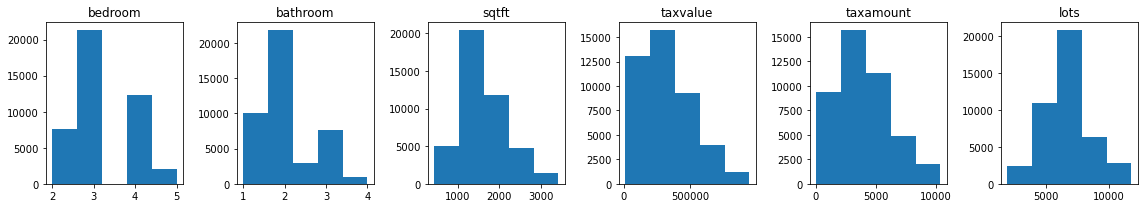

In [9]:
zillow_train,zillow_validate,zillow_test=wrangle_zillow(1.5)

In [10]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24257 entries, 9653 to 47564
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom          24257 non-null  float64
 1   bathroom         24257 non-null  float64
 2   sqtft            24257 non-null  float64
 3   taxvalue         24257 non-null  float64
 4   yearbuilt        24249 non-null  object 
 5   taxamount        24257 non-null  float64
 6   fips             24257 non-null  object 
 7   lots             24257 non-null  float64
 8   zipcode          24247 non-null  object 
 9   assessmentyear   24257 non-null  object 
 10  transactiondate  24257 non-null  object 
dtypes: float64(6), object(5)
memory usage: 2.2+ MB
